<a href="https://colab.research.google.com/github/ameralhomdy/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/module3-dimensionality-reduction/High_Dimensional_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

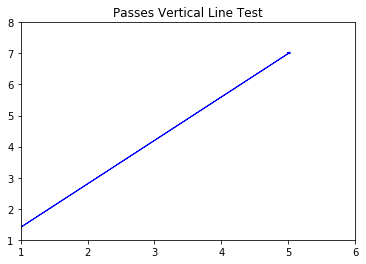

In [17]:
import numpy as np
import matplotlib.pyplot as plt


vector = [5, 7]

plt.arrow(0,0, vector[0], vector[1],head_width=.05, head_length=0.05, color ='blue')
plt.xlim(1,6)          
plt.ylim(1,8)
plt.title("Passes Vertical Line Test")
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


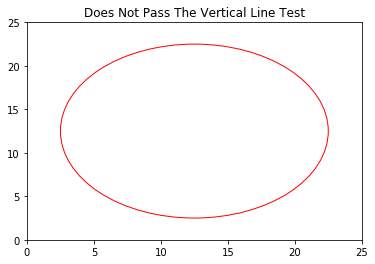

In [18]:
fig=plt.figure(1)
plt.axis([0,25,0,25])
ax=fig.add_subplot(1,1,1)
circ=plt.Circle((0.5,0.5), radius=0.4, color='red', fill=False,transform=ax.transAxes)
ax.add_patch(circ)
plt.title("Does Not Pass The Vertical Line Test")
plt.show()

## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

The circle isn't considered a function because they touch the Y axis more than once

# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

####Realtion 1 isn't a funtion because 2 outputs(2,3) are mapped to the same input(1)
####Realtion 2 is a funtion because there aren't 2 outputs that are mapped to the same input
####Realtion 3 isn't a funtion because 2 outputs(4,6) are mapped to the same input(9)
####Realtion 4 isn't a funtion because 2 outputs(2,4) are mapped to the same input(6)
####Realtion 1 isn't a funtion because multiple outputs(6,7,4) are mapped to the same input(2)

# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

####For m the dimensionality for the input is 3 and the output is 3
####For n the dimensionality for the input is 4 and the output is 2

## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

# Vector Transformations

## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

\begin{align}
p(\begin{bmatrix}3 \\ 4 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix} = \begin{bmatrix} 3 + (3 x 4) \\ (2 x 4) - 3 \\  \end{bmatrix} = \begin{bmatrix} 15 \\5 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}1 \\ 2 \\ 3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix} = \begin{bmatrix} 4 + 2 + (2 x 3) \\ (2 x 2) - 1 + (3 x 3) \\ 5 - (2 x 3) + 2  \end{bmatrix} = \begin{bmatrix} 12 \\ 12 \\ 1  \end{bmatrix}
\end{align}

## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

The eigenvalue is used to scale the eigenvector

The eigenvector is the vector that 

# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

- increased computational workload
- increased sparcity of data
- more difficult to explore the data and create the dimensions

## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

As a general rule of thumb, you should have 5 times the number of parameters. If the parameters are greater than or equal to the number of observations, you are in danger of overfitting your model.

# Principal Component Analysis

## 7.1 Code for loading and cleaning the 2013 national dataset from the [Housing Affordability Data System (HADS)](https://www.huduser.gov/portal/datasets/hads/hads.html) --housing data, can be found below. 

## Perform PCA on the processed dataset `national_processed` (Make sure you standardize your data!) and then make a scatterplot of PC1 against PC2. Some of our discussion and work around PCA with this dataset will continue during tomorrow's lecture and assignment.

Not only does this dataset have decent amount columns to begin with (99), but in preparing the data for PCA we have also [one-hot-encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f#targetText=One%20hot%20encoding%20is%20a,the%20entry%20in%20the%20dataset.) all of the categorical variables. This has the effect of creating a new column for each individual category of each categorical variable. After processing this dataset has 64738 columns. --Das a lot of columns.

Don't worry too much about the mechanics of one-hot encoding right now, you will learn and experiment with a whole bunch of categorical encoding approaches in unit 2. 

The code below will read in the dataset and perform the one-hot encoding of the categorical variables. Start adding your PCA code at the bottom of the provided code.

In [0]:
import os.path
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import pandas as pd

# Read National Data 
national_url = 'https://www.huduser.gov/portal/datasets/hads/hads2013n_ASCII.zip'
national_file = 'thads2013n.txt'

if os.path.exists(national_file):
    national = pd.read_csv(national_file)
else: 
    z_national = urlopen(national_url)
    zip_national = ZipFile(BytesIO(z_national.read())).extract(national_file)
    national = pd.read_csv(zip_national)

In [28]:
# Look at first 5 rows
print(national.shape)
national.head()

(64535, 99)


,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,BEDRMS,BUILT,STATUS,TYPE,VALUE,VACANCY,TENURE,NUNITS,ROOMS,WEIGHT,PER,ZINC2,ZADEQ,ZSMHC,STRUCTURETYPE,OWNRENT,UTILITY,OTHERCOST,COST06,COST12,COST08,COSTMED,TOTSAL,ASSISTED,GLMED,GL30,GL50,GL80,APLMED,ABL30,...,COST08RELPOVCAT,COST08RELFMRPCT,COST08RELFMRCAT,COST12RELAMIPCT,COST12RELAMICAT,COST12RELPOVPCT,COST12RELPOVCAT,COST12RELFMRPCT,COST12RELFMRCAT,COSTMedRELAMIPCT,COSTMedRELAMICAT,COSTMedRELPOVPCT,COSTMedRELPOVCAT,COSTMedRELFMRPCT,COSTMedRELFMRCAT,FMTZADEQ,FMTMETRO3,FMTBUILT,FMTSTRUCTURETYPE,FMTBEDRMS,FMTOWNRENT,FMTCOST06RELPOVCAT,FMTCOST08RELPOVCAT,FMTCOST12RELPOVCAT,FMTCOSTMEDRELPOVCAT,FMTINCRELPOVCAT,FMTCOST06RELFMRCAT,FMTCOST08RELFMRCAT,FMTCOST12RELFMRCAT,FMTCOSTMEDRELFMRCAT,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS
0,'100003130103',82,'3','1',73738,956,15738,26213,40322,11067,2,2006,'1',1,40000,-6,'1',1,6,3117.394239,1,18021,'1',533,1,'1',169.000000,213.750000,648.588189,803.050535,696.905247,615.156712,0,-9,73738,15738,26213,40322,51616.6,20234.571429,...,4,72.898038,2,48.402635,2,290.250487,4,84.001102,2,37.077624,2,222.339102,4,64.346936,2,'1 Adequate','-5','2000-2009','1 Single Family','2 2BR','1 Owner','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','3 150-200% Poverty','2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','1 LTE 50% FMR','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','.','2 30% to 50%','-5','-5'
1,'100006110249',50,'5','3',55846,1100,17165,28604,45744,24218,4,1980,'1',1,130000,-6,'1',1,6,2150.725544,4,122961,'1',487,1,'1',245.333333,58.333333,1167.640781,1669.643405,1324.671218,1058.988479,123000,-9,55846,17165,28604,45744,55846.0,19911.400000,...,4,120.424656,3,103.094063,6,275.768999,4,151.785764,3,65.388468,4,174.909320,3,96.271680,2,'1 Adequate','-5','1980-1989','1 Single Family','4 4BR+','1 Owner','3 150-200% Poverty','4 200%+ Poverty','4 200%+ Poverty','3 150-200% Poverty','4 200%+ Poverty','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','3 GT FMR','4 60 - 80% AMI','4 60 - 80% AMI','6 100 - 120% AMI','4 60 - 80% AMI','7 120% AMI +','.','1 Less than 30%','-5','-5'
2,'100006370140',53,'5','3',55846,1100,13750,22897,36614,15470,4,1985,'1',1,150000,-6,'1',1,7,2213.789404,2,27974,'1',1405,1,'1',159.000000,37.500000,1193.393209,1772.627006,1374.582175,1068.025168,28000,-9,55846,13750,22897,36614,44676.8,19937.500000,...,4,124.962016,3,109.452905,6,458.339239,4,161.147910,3,65.946449,4,276.153890,4,97.093197,2,'1 Adequate','-5','1980-1989','1 Single Family','4 4BR+','1 Owner','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','3 150-200% Poverty','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','4 60 - 80% AMI','5 80 - 100% AMI','6 100 - 120% AMI','4 60 - 80% AMI','4 60 - 80% AMI','.','3 50% or More','-5','-5'
3,'100006520140',67,'5','3',55846,949,13750,22897,36614,13964,3,1985,'1',1,200000,-6,'1',1,6,2364.585097,2,32220,'1',279,1,'1',179.000000,70.666667,1578.857612,2351.169341,1820.442900,1411.700224,0,-9,55846,13750,22897,36614,44676.8,17875.000000,...,4,191.827492,3,161.926709,7,673.494512,4,247.752301,3,97.224801,5,404.382763,4,148.756610,3,'1 Adequate','-5','1980-1989','1 Single Family','3 3BR','1 Owner','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','3 GT FMR','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','6 100 - 120% AMI','7 120% AMI +','7 120% AMI +','5 80 - 100% AMI','4 60 - 80% AMI','.','1 Less than 30%','-5','-5'
4,'100007130148',26,'1','3',60991,737,14801,24628,39421,15492,2,1980,'1',1,-6,-6,'2',100,4,2314.524902,2,96874,'1',759,5,'2',146.000000,12.500000,759.000000,759.000000,759.000000,759.000000,96900,0,60991,14801,24628,39421,48792.8,16651.125000,...,3,102.985075,3,55.308707,3,195.972115,3,102.985075,3,55.308707,3,195.972115,3,102.98

In [29]:
# Look at datatypes
# a lot of object datatypes even though they look to be strings of numbers.
national.dtypes

CONTROL                 object
AGE1                     int64
METRO3                  object
REGION                  object
LMED                     int64
FMR                      int64
L30                      int64
L50                      int64
L80                      int64
IPOV                     int64
BEDRMS                   int64
BUILT                    int64
STATUS                  object
TYPE                     int64
VALUE                    int64
VACANCY                  int64
TENURE                  object
NUNITS                   int64
ROOMS                    int64
WEIGHT                 float64
PER                      int64
ZINC2                    int64
ZADEQ                   object
ZSMHC                    int64
STRUCTURETYPE            int64
OWNRENT                 object
UTILITY                float64
OTHERCOST              float64
COST06                 float64
COST12                 float64
                        ...   
COSTMedRELAMICAT         int64
COSTMedR

In [30]:
# check for null values
national.isnull().sum().any()

False

In [31]:
# check for number of categorical vs numeric columns
cat_cols = national.columns[national.dtypes=='object']
num_cols = national.columns[national.dtypes!='object']

print(f'{len(cat_cols)} categorical columns')
print(f'{len(num_cols)} numerical columns')

32 categorical columns
67 numerical columns


In [32]:
national_processed = national.copy()

# Get One-Hot-Encoding of categorical variables
national_processed = pd.get_dummies(national_processed)
print(national_processed.shape)
national_processed.head()

(64535, 64738)


,AGE1,LMED,FMR,L30,L50,L80,IPOV,BEDRMS,BUILT,TYPE,VALUE,VACANCY,NUNITS,ROOMS,WEIGHT,PER,ZINC2,ZSMHC,STRUCTURETYPE,UTILITY,OTHERCOST,COST06,COST12,COST08,COSTMED,TOTSAL,ASSISTED,GLMED,GL30,GL50,GL80,APLMED,ABL30,ABL50,ABL80,ABLMED,BURDEN,INCRELAMIPCT,INCRELAMICAT,INCRELPOVPCT,...,FMTCOST08RELAMICAT_'1 LTE 30% AMI',FMTCOST08RELAMICAT_'2 30 - 50% AMI',FMTCOST08RELAMICAT_'3 50 - 60% AMI',FMTCOST08RELAMICAT_'4 60 - 80% AMI',FMTCOST08RELAMICAT_'5 80 - 100% AMI',FMTCOST08RELAMICAT_'6 100 - 120% AMI',FMTCOST08RELAMICAT_'7 120% AMI +',FMTCOST12RELAMICAT_'1 LTE 30% AMI',FMTCOST12RELAMICAT_'2 30 - 50% AMI',FMTCOST12RELAMICAT_'3 50 - 60% AMI',FMTCOST12RELAMICAT_'4 60 - 80% AMI',FMTCOST12RELAMICAT_'5 80 - 100% AMI',FMTCOST12RELAMICAT_'6 100 - 120% AMI',FMTCOST12RELAMICAT_'7 120% AMI +',FMTCOSTMEDRELAMICAT_'1 LTE 30% AMI',FMTCOSTMEDRELAMICAT_'2 30 - 50% AMI',FMTCOSTMEDRELAMICAT_'3 50 - 60% AMI',FMTCOSTMEDRELAMICAT_'4 60 - 80% AMI',FMTCOSTMEDRELAMICAT_'5 80 - 100% AMI',FMTCOSTMEDRELAMICAT_'6 100 - 120% AMI',FMTCOSTMEDRELAMICAT_'7 120% AMI +',FMTINCRELAMICAT_'.',FMTINCRELAMICAT_'1 LTE 30% AMI',FMTINCRELAMICAT_'2 30 - 50% AMI',FMTINCRELAMICAT_'3 50 - 60% AMI',FMTINCRELAMICAT_'4 60 - 80% AMI',FMTINCRELAMICAT_'5 80 - 100% AMI',FMTINCRELAMICAT_'6 100 - 120% AMI',FMTINCRELAMICAT_'7 120% AMI +',FMTASSISTED_'.',FMTASSISTED_'0 Not Assisted',FMTASSISTED_'1 Assisted',FMTBURDEN_'.',FMTBURDEN_'1 Less than 30%',FMTBURDEN_'2 30% to 50%',FMTBURDEN_'3 50% or More',FMTBURDEN_'4 No Income',FMTREGION_'-5',FMTREGION_'West',FMTSTATUS_'-5'
0,82,73738,956,15738,26213,40322,11067,2,2006,1,40000,-6,1,6,3117.394239,1,18021,533,1,169.000000,213.750000,648.588189,803.050535,696.905247,615.156712,0,-9,73738,15738,26213,40322,51616.6,20234.571429,33702.428571,51842.571429,66364.20,0.354919,34.913187,2,162.835457,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1
1,50,55846,1100,17165,28604,45744,24218,4,1980,1,130000,-6,1,6,2150.725544,4,122961,487,1,245.333333,58.333333,1167.640781,1669.643405,1324.671218,1058.988479,123000,-9,55846,17165,28604,45744,55846.0,19911.400000,33180.640000,53063.040000,64781.36,0.047527,220.178706,7,507.725659,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1
2,53,55846,1100,13750,22897,36614,15470,4,1985,1,150000,-6,1,7,2213.789404,2,27974,1405,1,159.000000,37.500000,1193.393209,1772.627006,1374.582175,1068.025168,28000,-9,55846,13750,22897,36614,44676.8,19937.500000,33200.650000,53090.300000,64781.36,0.602703,62.614153,4,180.827408,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1
3,67,55846,949,13750,22897,36614,13964,3,1985,1,200000,-6,1,6,2364.585097,2,32220,279,1,179.000000,70.666667,1578.857612,2351.169341,1820.442900,1411.700224,0,-9,55846,13750,22897,36614,44676.8,17875.000000,29766.100000,47598.200000,58079.84,0.103911,72.117967,4,230.736179,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1
4,26,60991,737,14801,24628,39421,15492,2,1980,1,-6,-6,100,4,2314.524902,2,96874,759,5,146.000000,12.500000,759.000000,759.000000,759.000000,759.000000,96900,0,60991,14801,24628,39421,48792.8,16651.125000,27706.500000,44348.625000,54891.90,0.094019,198.541588,7,625.316292,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1


In [41]:
### Your Code Here
num_cols.tolist

<bound method IndexOpsMixin.tolist of Index(['AGE1', 'LMED', 'FMR', 'L30', 'L50', 'L80', 'IPOV', 'BEDRMS', 'BUILT',
       'TYPE', 'VALUE', 'VACANCY', 'NUNITS', 'ROOMS', 'WEIGHT', 'PER', 'ZINC2',
       'ZSMHC', 'STRUCTURETYPE', 'UTILITY', 'OTHERCOST', 'COST06', 'COST12',
       'COST08', 'COSTMED', 'TOTSAL', 'ASSISTED', 'GLMED', 'GL30', 'GL50',
       'GL80', 'APLMED', 'ABL30', 'ABL50', 'ABL80', 'ABLMED', 'BURDEN',
       'INCRELAMIPCT', 'INCRELAMICAT', 'INCRELPOVPCT', 'INCRELPOVCAT',
       'INCRELFMRPCT', 'INCRELFMRCAT', 'COST06RELAMIPCT', 'COST06RELAMICAT',
       'COST06RELPOVPCT', 'COST06RELPOVCAT', 'COST06RELFMRPCT',
       'COST06RELFMRCAT', 'COST08RELAMIPCT', 'COST08RELAMICAT',
       'COST08RELPOVPCT', 'COST08RELPOVCAT', 'COST08RELFMRPCT',
       'COST08RELFMRCAT', 'COST12RELAMIPCT', 'COST12RELAMICAT',
       'COST12RELPOVPCT', 'COST12RELPOVCAT', 'COST12RELFMRPCT',
       'COST12RELFMRCAT', 'COSTMedRELAMIPCT', 'COSTMedRELAMICAT',
       'COSTMedRELPOVPCT', 'COSTMedRELPOVCAT',

In [0]:
from numpy import array
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [0]:
num_cols2 = national.select_dtypes(exclude='object')

In [45]:
num_cols2.shape

(64535, 67)

In [47]:
# Principal Component Analysis
from numpy import array
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# define a matrix
X = num_cols2
print("Data: \n", X)
# Standardize the Data
# Instantiate a Standard Scaler object
scaler = StandardScaler()
# Use the object to fit_transform our data
Z = scaler.fit_transform(X)
print("\n Standardized Data: \n", Z)
# create the PCA instance
# The integer value that we're passing in says 
# how many new columns we want to retain from PCA
pca = PCA(2)
# fit on data
pca.fit(Z)
# access values and vectors
print("\n Eigenvectors: \n", pca.components_)
print("\n Eigenvalues: \n",pca.explained_variance_)
# transform data
B = pca.transform(Z)
print("\n Projected Data: \n", B)

Data: 
        AGE1    LMED   FMR  ...  COSTMedRELPOVCAT  COSTMedRELFMRPCT  COSTMedRELFMRCAT
0        82   73738   956  ...                 4         64.346936                 2
1        50   55846  1100  ...                 3         96.271680                 2
2        53   55846  1100  ...                 4         97.093197                 2
3        67   55846   949  ...                 4        148.756610                 3
4        26   60991   737  ...                 3        102.985075                 3
5        56   62066   657  ...                 4        105.783866                 3
6        50   60991   988  ...                 4        184.376885                 3
7        26   52322   773  ...                 4        126.261320                 3
8        60   50296  1125  ...                 4        108.383276                 3
9        26   63221   552  ...                 4        199.275362                 3
10       59   55846   949  ...                 4        1

# Stretch Goals

## 1) Perform further data exploration on the HADS national dataset (the version before we one-hot encoded it) Make scatterplots and see if you can see any resemblance between the original scatterplots and the plot of the principal components that you made in 7.1. 

(You may or may not not see very much resemblance depending on the variables you choose, and that's ok!)

## 2) Study "Scree Plots" and then try and make one for your PCA dataset. How many principal conponents do you need to retain in order for your PCs to contain 90% of the explained variance? 

We will present this topic formally at the beginning of tomorrow's lecture, so if you figure this stretch goal out, you're ahead of the game. 

## 3) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

Prioritize self-study over this stretch goal if you are not semi-comfortable with the topics of PCA, Eigenvalues, and Eigenvectors.

![Eigenfaces](https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg)

You don't necessarily have to use this resource, but this will get you started: 
[Eigenface Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)